In [82]:
!pip install shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from google.colab import drive
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ProcessPoolExecutor
import logging
from sklearn.feature_selection import SelectFromModel
from joblib import Parallel, delayed
import matplotlib
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 4.0 MB/s eta 0:00:00


In [19]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
df=pd.read_csv('/content/drive/My Drive/archive/bird_songs_metadata.csv')
df.head()

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [21]:
# List for storing the filepaths and labels
file_paths = []
labels = []
audio_dir = '/content/drive/MyDrive/archive/wavfiles/'

for filename, species in df[['filename', 'species']].itertuples(index=False):
    file_path = Path(audio_dir) / filename
    if file_path.exists():
        file_paths.append(str(file_path))
        labels.append(species)
    else:
        print(f"File not found: {file_path}")

#first five elements of each list
print(file_paths[:5])
print(labels[:5])

['/content/drive/MyDrive/archive/wavfiles/557838-0.wav', '/content/drive/MyDrive/archive/wavfiles/557838-1.wav', '/content/drive/MyDrive/archive/wavfiles/557838-4.wav', '/content/drive/MyDrive/archive/wavfiles/557838-5.wav', '/content/drive/MyDrive/archive/wavfiles/557838-6.wav']
['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii']


In [51]:
# Function to load and process audio files
def load_and_process_audio(file_paths, sr, fixed_length):
    processed_audio = []
    for file_path in file_paths:
        try:
            audio, _ = librosa.load(file_path, sr=sr)
            if len(audio) > fixed_length:
                audio = audio[:fixed_length]
            else:
                audio = np.pad(audio, (0, max(0, fixed_length - len(audio))), 'constant')
            processed_audio.append(audio)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    return processed_audio

In [52]:
# Function to extract MFCC features
def extract_mfcc_features(audio_clips, sr, n_mfcc=13):
    def process_sound(sound):
        mfcc = librosa.feature.mfcc(y=sound, sr=sr, n_mfcc=n_mfcc)
        mfcc_scaled = np.mean(mfcc.T, axis=0)
        return mfcc_scaled

    mfcc_features = Parallel(n_jobs=-1)(delayed(process_sound)(sound) for sound in audio_clips)
    return np.array(mfcc_features)

# Function to extract log Mel spectrogram features
def extract_log_mel_features(audio_clips, sr, n_mels=128):
    def process_sound(sound):
        mel = librosa.feature.melspectrogram(y=sound, sr=sr, n_mels=n_mels)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_scaled = np.mean(mel_db.T, axis=0)
        return mel_scaled

    mel_features = Parallel(n_jobs=-1)(delayed(process_sound)(sound) for sound in audio_clips)
    return np.array(mel_features)

# Function to extract waveform features
def extract_waveform_features(audio_clips):
    def process_sound(sound):
        return np.mean(sound), np.std(sound), np.max(sound), np.min(sound)

    waveform_features = Parallel(n_jobs=-1)(delayed(process_sound)(sound) for sound in audio_clips)
    return np.array(waveform_features)

# Function to normalize features
def normalize_features(features):
    mean = np.mean(features, axis=0)
    std = np.std(features, axis=0)
    return (features - mean) / std

In [53]:
if __name__ == "__main__":
    # Variables
    fixed_length = 5 * 22050  # 5 seconds
    sr = 22050

    # Load and process audio files
    processed_audio = load_and_process_audio(file_paths, sr, fixed_length)

    # Extract MFCC features
    mfcc_features = extract_mfcc_features(processed_audio, sr)

    # Extract log Mel spectrogram features
    log_mel_features = extract_log_mel_features(processed_audio, sr)

    # Extract waveform features
    waveform_features = extract_waveform_features(processed_audio)

    # Combine all features
    combined_features = np.hstack([mfcc_features, log_mel_features, waveform_features])

    # Normalize features
    combined_features = normalize_features(combined_features)

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels)

    # Train-test split
    X_train, X_test, y_train, y_test, files_train, files_test = train_test_split(
        combined_features, y_encoded, file_paths, test_size=0.2, random_state=42
    )


In [54]:
# Instatiate XGBClassifier
xg_model=XGBClassifier(random_state=42)

In [55]:
# Inspect the parameters
xg_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [58]:
xg_model.set_params(n_estimators=100, booster='gbtree')

xg_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_model.predict(X_test)

In [70]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9179723502304148


In [68]:
print("Classification Report", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report               precision    recall  f1-score   support

    bewickii       0.93      0.90      0.91       193
  cardinalis       0.90      0.88      0.89       204
     melodia       0.88      0.94      0.91       243
 migratorius       0.93      0.95      0.94       207
 polyglottos       0.95      0.92      0.93       238

    accuracy                           0.92      1085
   macro avg       0.92      0.92      0.92      1085
weighted avg       0.92      0.92      0.92      1085



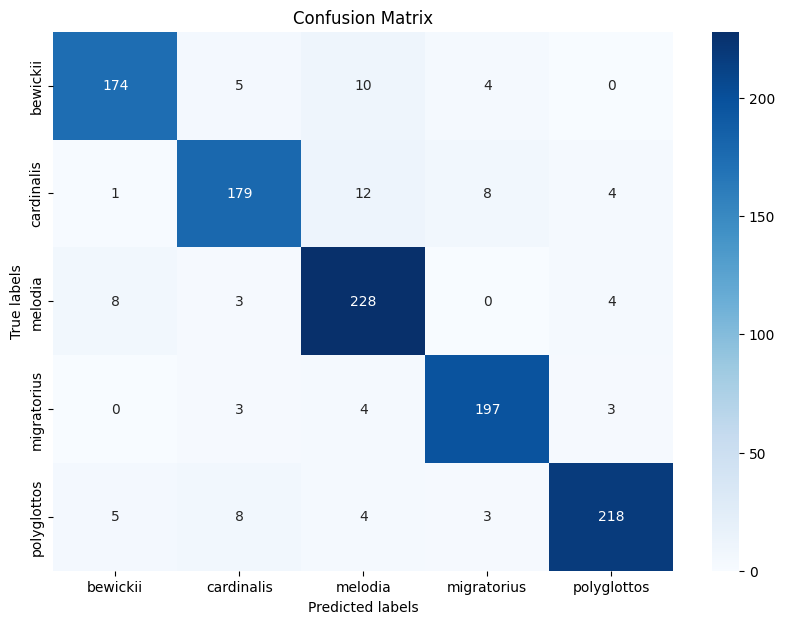

In [69]:
#confusion Matrix
cm = confusion_matrix(y_test, y_pred)

#Plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

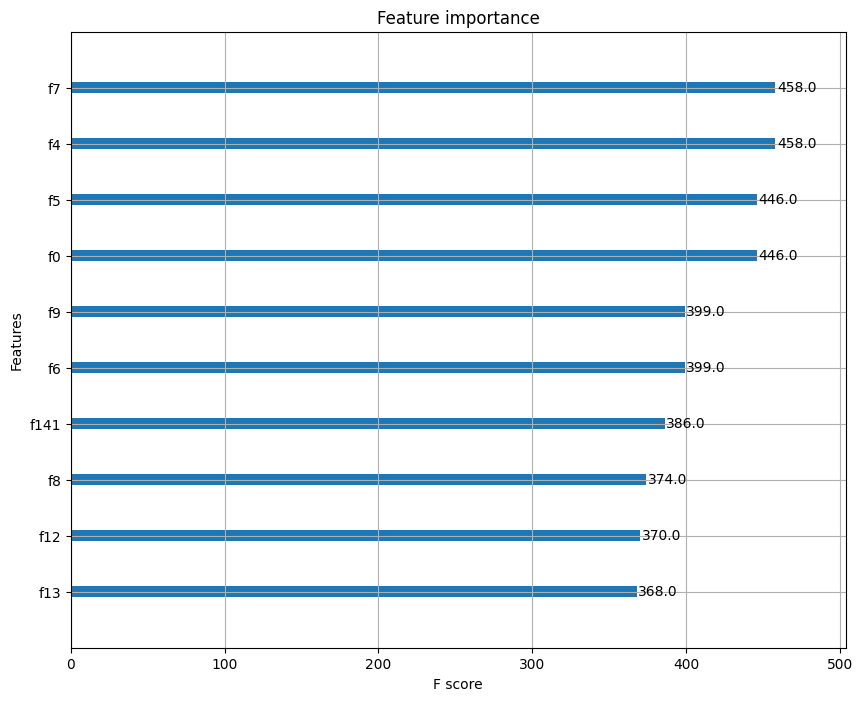

In [65]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8)
xgb.plot_importance(xg_model,  max_num_features=10)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

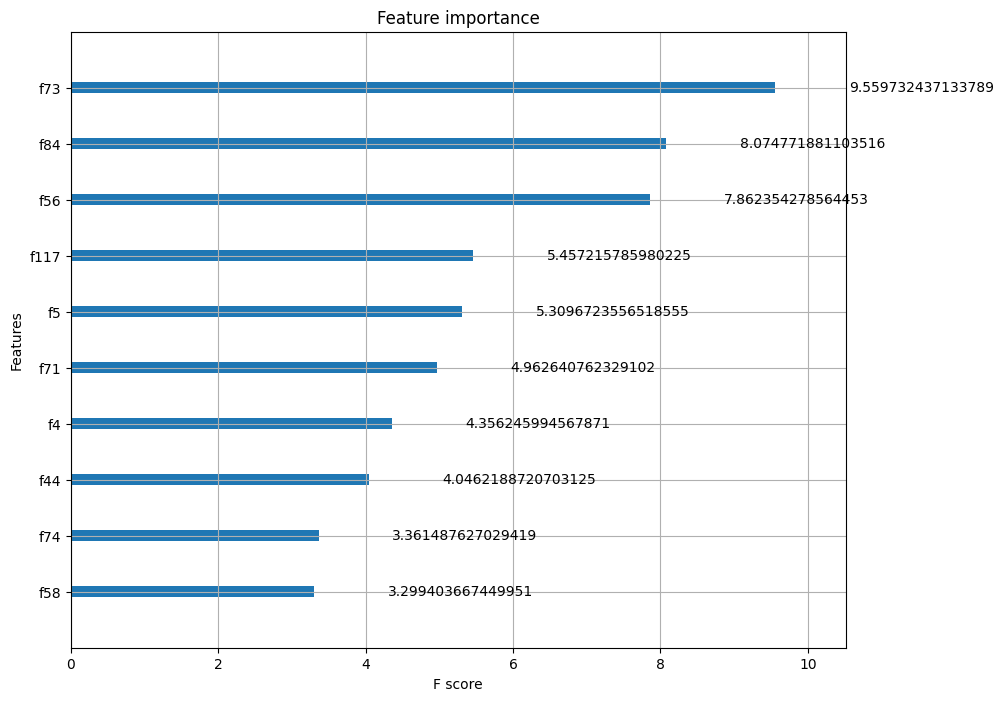

In [63]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8)

xgb.plot_importance(xg_model, importance_type='gain', max_num_features=10)

<Axes: >

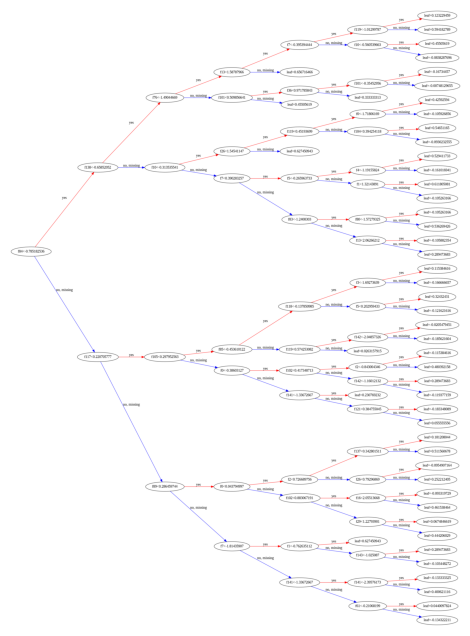

In [72]:
# Plot tree
matplotlib.rcParams['figure.figsize'] = (10.0, 8)

xgb.plot_tree(xg_model, num_trees=0, rankdir='LR')


In [85]:
# Create the SHAP explainer object
explainer = shap.TreeExplainer(xg_model)

# Calculate the SHAP values for the test set
shap_values = explainer.shap_values(X_test)

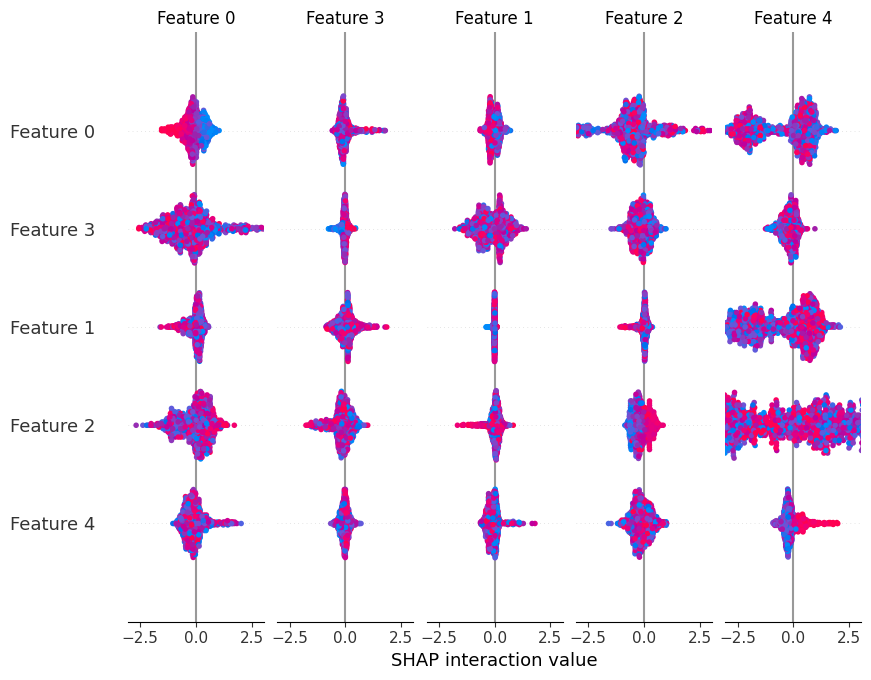

In [86]:
# Summary
shap.summary_plot(shap_values, X_test)

In [73]:
# Define a parameter grid
rs_param_grid = {
    'max_depth': list((range(3,12))),
    'alpha': [0,0.001, 0.01,0.1,1],
    'subsample': [0.5,0.75,1],
    'learning_rate': np.linspace(0.01,0.5, 10),
    'n_estimators': [10, 25, 40]
    }


In [74]:
# Insantiate XGBoost Clasifier
xgb_model2 = XGBClassifier(random_state=42)

# Instantiate RandomizedSearchCV
xgb_rs = RandomizedSearchCV(estimator=xgb_model2,param_distributions=rs_param_grid,
                                cv=3, n_iter=5, verbose=2, random_state=42)

# Train the model
xgb_rs.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END alpha=0.1, learning_rate=0.5, max_depth=4, n_estimators=40, subsample=0.5; total time=   3.0s
[CV] END alpha=0.1, learning_rate=0.5, max_depth=4, n_estimators=40, subsample=0.5; total time=   2.8s
[CV] END alpha=0.1, learning_rate=0.5, max_depth=4, n_estimators=40, subsample=0.5; total time=   6.6s
[CV] END alpha=1, learning_rate=0.17333333333333334, max_depth=5, n_estimators=40, subsample=0.5; total time=  19.7s
[CV] END alpha=1, learning_rate=0.17333333333333334, max_depth=5, n_estimators=40, subsample=0.5; total time=   6.1s
[CV] END alpha=1, learning_rate=0.17333333333333334, max_depth=5, n_estimators=40, subsample=0.5; total time=   8.3s
[CV] END alpha=0.001, learning_rate=0.01, max_depth=8, n_estimators=25, subsample=1; total time=  10.9s
[CV] END alpha=0.001, learning_rate=0.01, max_depth=8, n_estimators=25, subsample=1; total time=  12.5s
[CV] END alpha=0.001, learning_rate=0.01, max_depth=8, n_estimators=25, 

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=5,
                   param_distributions={'alpha': [0, 0.001, 0.01, 0.1, 1],
                                        'learning_rate': array([0.01      , 0.06444444, 0.11888889, 0.17333333, 0.22777778,
       0.28222222, 0.33666667, 0.39111111, 0.44555556, 0.5       ]),
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      11],
                                        'n_estimators': [10, 25, 40],
                                        'subsample': [0.5, 0.75, 1]},
                   random_state=42, verbose=2)

In [76]:
#best parameters and highest accuracy
print("Best parameters found: ", xgb_rs.best_params_)
print("Best accuracy found: ", xgb_rs.best_score_)

Best parameters found:  {'subsample': 0.75, 'n_estimators': 40, 'max_depth': 11, 'learning_rate': 0.2822222222222222, 'alpha': 0.001}
Best accuracy found:  0.868114242686742


In [78]:
rs_result=xgb_rs.cv_results_
rs_result

{'mean_fit_time': array([ 4.09309856, 11.34787114, 12.48583833, 14.00789142, 15.30541436]),
 'std_fit_time': array([1.70969391, 5.97980433, 1.30113371, 0.10870592, 0.42338229]),
 'mean_score_time': array([0.01972667, 0.00891829, 0.0108552 , 0.01471655, 0.01188811]),
 'std_score_time': array([1.73863401e-02, 2.66069651e-04, 1.68951226e-03, 7.80852291e-05,
        8.61194692e-05]),
 'param_subsample': masked_array(data=[0.5, 0.5, 1, 0.75, 1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[40, 40, 25, 40, 25],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[4, 5, 8, 11, 11],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.5, 0.17333333333333334, 0.01, 0.2822222222222222,
                

In [79]:
results_df = pd.DataFrame(rs_result)

In [80]:
# Display the columns of the DataFrame
print(results_df.columns)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_subsample', 'param_n_estimators', 'param_max_depth',
       'param_learning_rate', 'param_alpha', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')


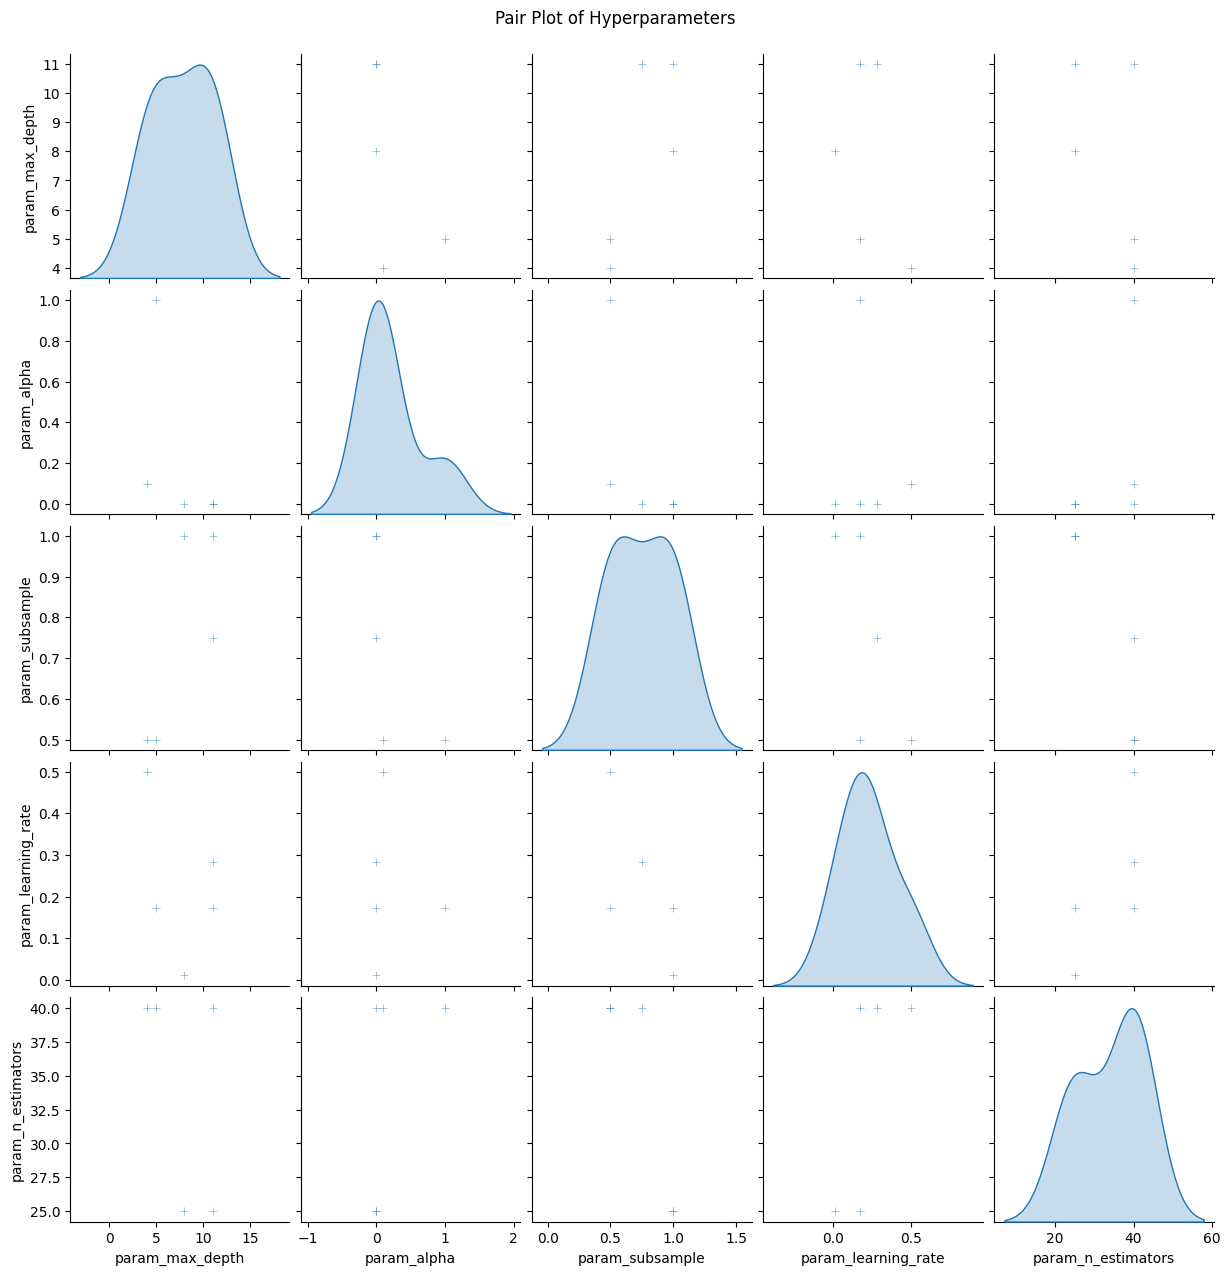

In [81]:
# Select relevant columns for the pair plot
pair_plot_data = results_df[['param_max_depth', 'param_alpha', 'param_subsample', 'param_learning_rate', 'param_n_estimators']]

# Create the pair plot
sns.pairplot(pair_plot_data, diag_kind='kde', markers='+', plot_kws={'alpha': 0.6})
plt.suptitle('Pair Plot of Hyperparameters', y=1.02)
plt.show()
